##**CSI4142 - Assignment 4**


#**Group 91**

Aimen Mossa - 300209397


##**Introduction**
This notebook presents Assignment 4, where we explore unsupervised learning techniques through clustering and recommendation systems using the Amazon Apparels dataset. The notebook is organized as follows:
1. **Dataset Description:** Overview of the Amazon Apparels metadata and reviews.
2. **Data Preparation:** Initial EDA, data cleaning, and feature engineering.
3. **Study 1 – Similarity Measures:** Experimenting with various similarity measures (including a text-based measure) on selected product attributes.
4. **Study 2 – Clustering Algorithms:** Application and visualization of KMeans and DBSCAN clustering on two combinations of attributes.
5. **Study 3 – Content-Based Recommendation:** Developing two content-based recommendation heuristics and comparing their top recommendations.
6. **Study 4 – Collaborative Filtering:** Building a utility matrix from user reviews, performing matrix factorization, and evaluating the recommendation system quantitatively.
7. **Conclusion and References:** Summary of findings and list of references.



## **Dataset Description**

We use the **Amazon Apparels Data Review** dataset which consists of two files:

1. **Amazon-clothing-info.csv:** Contains metadata for clothing items. Key attributes (selected for this assignment) include:
   - `asin`: Unique product identifier.
   - `name`: Product title.
   - `brand`: Brand of the product.
   - `price`: Price of the product (numerical).
   - `color`: Color description.
   - `category`: Product category.

2. **Clothing-Reviews.csv:** Contains user reviews with attributes:
   - `asin`: To link reviews with product metadata.
   - `review_userId`: Unique user identifier.
   - `review_score`: Rating given by the user.

The dataset was chosen because it offers both metadata (for similarity, clustering, and content-based recommendations) and individual user ratings (for collaborative filtering).  
Data is read directly from our GitHub repository to ensure reproducibility.


# **Data Preparation and Initial EDA**


- We load the two datasets from the repos.
- The initial EDA shows the first few rows, column info, and a histogram of the product prices.
- Missing values and data types are inspected for further cleaning/feature engineering.


Amazon Clothing Info:
                    sku        asin product_type_name formatted_price author  \
0                   NaN  B004GSI2OS             SHIRT          $26.26    NaN   
1                   NaN  B012YX2ZPI             SHIRT           $9.99    NaN   
2                   NaN  B001LOUGE4             SHIRT          $11.99    NaN   
3  HT-2001_Lime-1149-XL  B003BSRPB0             SHIRT          $20.54    NaN   
4                   NaN  B014ICEDNA             SHIRT           $7.50    NaN   

               color                        brand publisher  \
0  Onyx Black/ Stone                  FeatherLite       NaN   
1              White  HX-Kingdom Fashion T-shirts       NaN   
2              Black                 Fitness Etc.       NaN   
3              White                  FeatherLite       NaN   
4             Purple                        FNC7C       NaN   

                          availability  \
0  Usually ships in 6-10 business days   
1   Usually ships in 4-5 business 

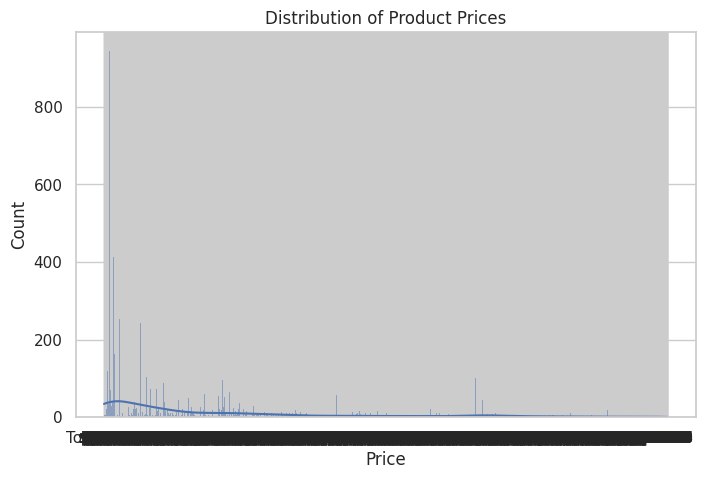

Missing values in clothing info:
 sku                  28261
asin                     0
product_type_name        0
formatted_price          0
author               28394
color                   10
brand                   93
publisher            20054
availability          3863
reviews                  0
large_image_url          0
availability_type     3836
small_image_url          0
editorial_review     27954
title                    0
model                20113
medium_image_url         0
manufacturer         20054
editorial_reivew      2841
dtype: int64


In [67]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#visual style
sns.set(style="whitegrid")

#Amazon clothing info data
info_url = "https://raw.githubusercontent.com/amoss102/CSI4142W25/3b142da730f09965a2753fa04ace9412566293ea/Amazon-clothing-info.csv"
clothing_info = pd.read_csv(info_url)

#Clothing Reviews data
reviews_url = "https://raw.githubusercontent.com/amoss102/CSI4142W25/3b142da730f09965a2753fa04ace9412566293ea/Clothing-Reviews.csv"
clothing_reviews = pd.read_csv(reviews_url)

# Displaying basic info
print("Amazon Clothing Info:")
print(clothing_info.head())
print(clothing_info.info())

print("\nClothing Reviews:")
print(clothing_reviews.head())
print(clothing_reviews.info())

# Ploting a graph for EDA
plt.figure(figsize=(8, 5))
sns.histplot(clothing_info['formatted_price'].dropna(), bins=30, kde=True)
plt.title("Distribution of Product Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Checking missing values in the clothing info dataset
missing_values = clothing_info.isnull().sum()
print("Missing values in clothing info:\n", missing_values)


### Data Preparation Summary
- We loaded the two datasets from the provided GitHub URLs.
- The initial EDA shows the first few rows, column info, and a histogram of the product prices.
- Missing values and data types are inspected for further cleaning/feature engineering.


##**Studies**
##**Study 1 – Similarity measures**

Parsing 'formatted_price'


In [68]:
import re

# Function to parse a price string into a float
def parse_price(price_str):
    if not isinstance(price_str, str):
        return None

    clean_str = re.sub(r'[^0-9\.]', '', price_str)
    try:
        return float(clean_str)
    except ValueError:
        return None

# new column "parsed_price"
clothing_info['parsed_price'] = clothing_info['formatted_price'].apply(parse_price)

# Show a few rows to verify
clothing_info[['formatted_price', 'parsed_price']].head(10)


,formatted_price,parsed_price
0,$26.26,26.26
1,$9.99,9.99
2,$11.99,11.99
3,$20.54,20.54
4,$7.50,7.50
5,$7.39,7.39
6,$13.53,13.53
7,$6.95,6.95
8,$7.90,7.90
9,$7.39,7.39


In [69]:
from difflib import SequenceMatcher
import pandas as pd
import numpy as np

########################
# Similarity Functions #
########################

def categorical_similarity(val1, val2):
    """
    Returns 1 if both categorical values match (case-insensitive),
    otherwise 0. If either is NaN, return 0.
    """
    if pd.isnull(val1) or pd.isnull(val2):
        return 0
    return 1 if val1.strip().lower() == val2.strip().lower() else 0

def numerical_similarity(val1, val2):
    """
    Returns a similarity in [0, 1] based on inverse difference:
    similarity = 1 / (1 + |val1 - val2|)
    """
    if pd.isnull(val1) or pd.isnull(val2):
        return 0
    return 1 / (1 + abs(val1 - val2))

def text_edit_similarity(str1, str2):
    """
    Returns a ratio in [0, 1] based on edit distance
    using SequenceMatcher.
    """
    if pd.isnull(str1) or pd.isnull(str2):
        return 0
    return SequenceMatcher(None, str1.lower(), str2.lower()).ratio()

#############################
# Helper Function to Get Top Similar Items #
#############################

def get_top_similar(df, target_index, attribute, similarity_func, top_n=10):
    """
    Given a DataFrame df, a target_index for a row,
    and a specified attribute & similarity_func,
    returns the top_n similar rows based on that attribute.
    """
    target_value = df.iloc[target_index][attribute]

    similarities = []
    for idx, row in df.iterrows():
        if idx == target_index:
            continue
        sim_score = similarity_func(target_value, row[attribute])
        similarities.append((idx, sim_score))

    # Sort by similarity score (descending order)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Retrieve top_n indices
    top_indices = [idx for idx, score in similarities[:top_n]]
    top_scores = [score for idx, score in similarities[:top_n]]

    # Create a result DataFrame
    result_df = df.iloc[top_indices].copy()
    result_df['similarity_score'] = top_scores
    return result_df


In [70]:
# ---------------------------
# Study 1: Simulating Similarity Requests
# ---------------------------

# Request 1: Similarity on Brand (categorical)
print("Request 1: Similarity on Brand for product at index 0")
reference_brand = clothing_info.iloc[0]['brand']
print("Reference brand:", reference_brand)
top_brand_similar = get_top_similar(clothing_info, 0, 'brand', categorical_similarity, top_n=10)
display(top_brand_similar[['asin', 'title', 'brand', 'similarity_score']].head(10))

# Request 2: Similarity on Price (numerical)
print("\nRequest 2: Similarity on Price for product at index 10")
reference_price = clothing_info.iloc[10]['parsed_price']
print("Reference parsed_price:", reference_price)
top_price_similar = get_top_similar(clothing_info, 10, 'parsed_price', numerical_similarity, top_n=10)
display(top_price_similar[['asin', 'title', 'formatted_price', 'parsed_price', 'similarity_score']].head(10))

# Request 3: Similarity on Color (categorical)
print("\nRequest 3: Similarity on Color for product at index 20")
reference_color = clothing_info.iloc[20]['color']
print("Reference color:", reference_color)
top_color_similar = get_top_similar(clothing_info, 20, 'color', categorical_similarity, top_n=10)
display(top_color_similar[['asin', 'title', 'color', 'similarity_score']].head(10))

# Request 4: Similarity on Product Type Name (categorical)
print("\nRequest 4: Similarity on Product Type for product at index 30")
reference_product_type = clothing_info.iloc[30]['product_type_name']
print("Reference product_type_name:", reference_product_type)
top_product_type_similar = get_top_similar(clothing_info, 30, 'product_type_name', categorical_similarity, top_n=10)
display(top_product_type_similar[['asin', 'title', 'product_type_name', 'similarity_score']].head(10))

# Request 5: Similarity on Title (text-based)
print("\nRequest 5: Similarity on Title for product at index 40")
reference_title = clothing_info.iloc[40]['title']
print("Reference title:", reference_title)
top_title_similar = get_top_similar(clothing_info, 40, 'title', text_edit_similarity, top_n=10)
display(top_title_similar[['asin', 'title', 'similarity_score']].head(10))


Request 1: Similarity on Brand for product at index 0
Reference brand: FeatherLite


,asin,title,brand,similarity_score
3,B003BSRPB0,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite,1
6,B0079BMKDS,Featherlite Ladies' Silky Smooth Pique (White)...,FeatherLite,1
11,B003BTPVGA,FeatherLite Ladies Long Sleeve Stain Resistant...,FeatherLite,1
15,B0079BM3A8,Featherlite Ladies' Silky Smooth Pique (Red) (3X),FeatherLite,1
19,B00BXOQ3X0,Featherlite Ladies' Silky Smooth Pique (Coffee...,FeatherLite,1
26,B003BSQ0WU,"FeatherLite Ladies' Pique Sport Shirt, Red , M...",FeatherLite,1
27,B003BSPZ5I,"FeatherLite Ladies' Pique Sport Shirt, Forest ...",FeatherLite,1
28,B0079BM2EA,Featherlite Ladies' Silky Smooth Pique (Red) (2X),FeatherLite,1
39,B003BSNV0O,"FeatherLite Ladies' Pique Sport Shirt, Forest ...",FeatherLite,1
43,B003BTPVHE,FeatherLite Ladies Long Sleeve Stain Resistant...,FeatherLite,1



Request 2: Similarity on Price for product at index 10
Reference parsed_price: 72.4


,asin,title,formatted_price,parsed_price,similarity_score
24722,B0758KC16Q,DKNY Women's Petite Crewneck Solid Knit Top Wo...,$72.42,72.42,0.980392
9789,B074G51BBP,Ermanno Scervino Lingerie Blue Crewneck Cotton...,$72.50,72.50,0.909091
12788,B074PMCRYN,Eileen Fisher Women's Organic Linen Asymmetric...,$72.50,72.50,0.909091
18666,B072NZ2HYN,Polo Ralph Lauren Women's Button Placket Solid...,$72.65,72.65,0.800000
23618,B00YWKNKN8,Denim & Supply Ralph Lauren Womens Chiffon Ple...,$72.65,72.65,0.800000
513,B01NA010Q6,ALO Women's Mantra Long Sleeve Alloy Shirt,$72.00,72.00,0.714286
1508,B06W2N15QZ,Aqua Girls' Watercolor Chevron Chiffon Dress M...,$72.00,72.00,0.714286
1720,B01MUVH8HU,ALO Women's Mantra Long Sleeve Alloy Shirt,$72.00,72.00,0.714286
2185,B01N9ZYT8S,ALO Women's Mantra Long Sleeve Alloy Shirt,$72.00,72.00,0.714286
2197,B01N4WCIBJ,ALO Women's Mantra Long Sleeve Alloy Shirt,$72.00,72.00,0.714286



Request 3: Similarity on Color for product at index 20
Reference color: Red


,asin,title,color,similarity_score
15,B0079BM3A8,Featherlite Ladies' Silky Smooth Pique (Red) (3X),Red,1
26,B003BSQ0WU,"FeatherLite Ladies' Pique Sport Shirt, Red , M...",Red,1
28,B0079BM2EA,Featherlite Ladies' Silky Smooth Pique (Red) (2X),Red,1
71,B014ICC10C,Supernatural Chibis Sam Dean And Castiel Cotto...,Red,1
82,B003BSPV48,FeatherLite Ladies' Moisture Free Mesh Sport S...,Red,1
103,B003BSRTY8,"FeatherLite Ladies' Pique Sport Shirt, Red , L...",Red,1
108,B003BSPV8E,FeatherLite Ladies' Moisture Free Mesh Sport S...,Red,1
111,B014ICBSE2,Supernatural Chibis Sam Dean And Castiel Short...,Red,1
118,B008PYJGRG,Woman Plus Size Seamless Thin Strap Cami Red,Red,1
141,B014QNNUDK,Women's Baylor Bears Football Logo O-neck T-sh...,Red,1



Request 4: Similarity on Product Type for product at index 30
Reference product_type_name: SHIRT


,asin,title,product_type_name,similarity_score
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,SHIRT,1
1,B012YX2ZPI,Women's Unique 100% Cotton T - Special Olympic...,SHIRT,1
2,B001LOUGE4,Ladies Cotton Tank 2x1 Ribbed Tank Top,SHIRT,1
3,B003BSRPB0,FeatherLite Ladies' Moisture Free Mesh Sport S...,SHIRT,1
4,B014ICEDNA,Supernatural Chibis Sam Dean And Castiel Short...,SHIRT,1
5,B014ICEJ1Q,Supernatural Chibis Sam Dean And Castiel O Nec...,SHIRT,1
7,B01NACPBG2,Fifth Degree Womens Gold Foil Graphic Tees Jun...,SHIRT,1
8,B00480IRZS,Ladies Green Seamless Ribbed Diamond Patterned...,SHIRT,1
10,B011YPK0MW,Feel The Piece Sami Dip Dye Top One Size in Navy,SHIRT,1
11,B003BTPVGA,FeatherLite Ladies Long Sleeve Stain Resistant...,SHIRT,1



Request 5: Similarity on Title for product at index 40
Reference title: Fashion Story Women's Casual Oversized Long Batwing Sleeve Baggy Shirt Pullover Blouse Tops


,asin,title,similarity_score
65,B074KGP484,Fashion Story Women's Casual Oversized Long Ba...,1.0
76,B074K6MY5V,Fashion Story Women's Casual Oversized Long Ba...,1.0
152,B074K41QHH,Fashion Story Women's Casual Oversized Long Ba...,1.0
184,B074KHNJNB,Fashion Story Women's Casual Oversized Long Ba...,1.0
269,B074JYZRZY,Fashion Story Women's Casual Oversized Long Ba...,1.0
336,B074K1SZD9,Fashion Story Women's Casual Oversized Long Ba...,1.0
395,B074K1NBTZ,Fashion Story Women's Casual Oversized Long Ba...,1.0
410,B074JXHMC9,Fashion Story Women's Casual Oversized Long Ba...,1.0
461,B074JZ3PKW,Fashion Story Women's Casual Oversized Long Ba...,1.0
462,B074JYH75V,Fashion Story Women's Casual Oversized Long Ba...,1.0


##**Study 2 – Clustering algorithms**


In [71]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Creates log_price as a new column based on parsed_price
clothing_info['log_price'] = clothing_info['parsed_price'].apply(lambda x: np.log(x) if x and x > 0 else None)

# Selects features for clustering: parsed_price and log_price
# clustering_features = clothing_info[['parsed_price', 'log_price']].dropna()

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(clustering_features)

print("Clustering features shape:", clustering_features.shape)
print("First 5 rows of clustering features:")
print(clustering_features.head())


Clustering features shape: (28375, 2)
First 5 rows of clustering features:
   parsed_price  log_price
0         26.26   3.268047
1          9.99   2.301585
2         11.99   2.484073
3         20.54   3.022374
4          7.50   2.014903


## **Data Preparation for Clustering**

### **Combination 1: Price and Availability**

In order to cluster our items, we need numeric features. We decided to use two features one derived from the product price and the other from availability:



- **parsed_price:** The numerical price parsed from the `formatted_price` column.
- **shipping_days:** A numerical value derived from the `availability` column. We extract the numbers (which represent the range of shipping days, e.g., "6-10") and compute their average. For example, if the text says "Usually ships in 6-10 business days," the shipping_days will be calculated as (6+10)/2 = 8.

The intuition here is to investigate whether there is a relationship between the product price and the shipping time, and whether clustering these two features reveals distinct groups in our dataset.


In [72]:

import re

def parse_availability(avail_text):
    """
    Extracts numbers from the availability text and returns their average.
    For example, "Usually ships in 6-10 business days" -> (6 + 10)/2 = 8.
    """
    if not isinstance(avail_text, str):
        return None
    numbers = re.findall(r'\d+', avail_text)
    if len(numbers) == 0:
        return None
    numbers = list(map(float, numbers))
    return sum(numbers) / len(numbers)

# Create a new column 'shipping_days' by applying the function on the 'availability' column
clothing_info['shipping_days'] = clothing_info['availability'].apply(parse_availability)

# Display the first few rows to verify the transformation
print("Availability and Shipping Days:")
print(clothing_info[['availability', 'shipping_days']].head(10))


Availability and Shipping Days:
                          availability  shipping_days
0  Usually ships in 6-10 business days            8.0
1   Usually ships in 4-5 business days            4.5
2                                  NaN            NaN
3  Usually ships in 6-10 business days            8.0
4   Usually ships in 4-5 business days            4.5
5   Usually ships in 4-5 business days            4.5
6   Usually ships in 2-3 business days            2.5
7   Usually ships in 1-2 business days            1.5
8   Usually ships in 1-2 business days            1.5
9   Usually ships in 4-5 business days            4.5


### **Preparing Features for Clustering**

In [73]:
from sklearn.preprocessing import StandardScaler

# Selects features: parsed_price and shipping_days
combination_features = clothing_info[['parsed_price', 'shipping_days']].dropna()

# Standardize the features
scaler3 = StandardScaler()
X3 = scaler3.fit_transform(combination_features)

print("Combination Features Shape:", combination_features.shape)
print("First 5 rows of the combination features:")
print(combination_features.head())


Combination Features Shape: (24505, 2)
First 5 rows of the combination features:
   parsed_price  shipping_days
0         26.26            8.0
1          9.99            4.5
3         20.54            8.0
4          7.50            4.5
5          7.39            4.5


**KMeans Clustering on [parsed_price, shipping_days]**

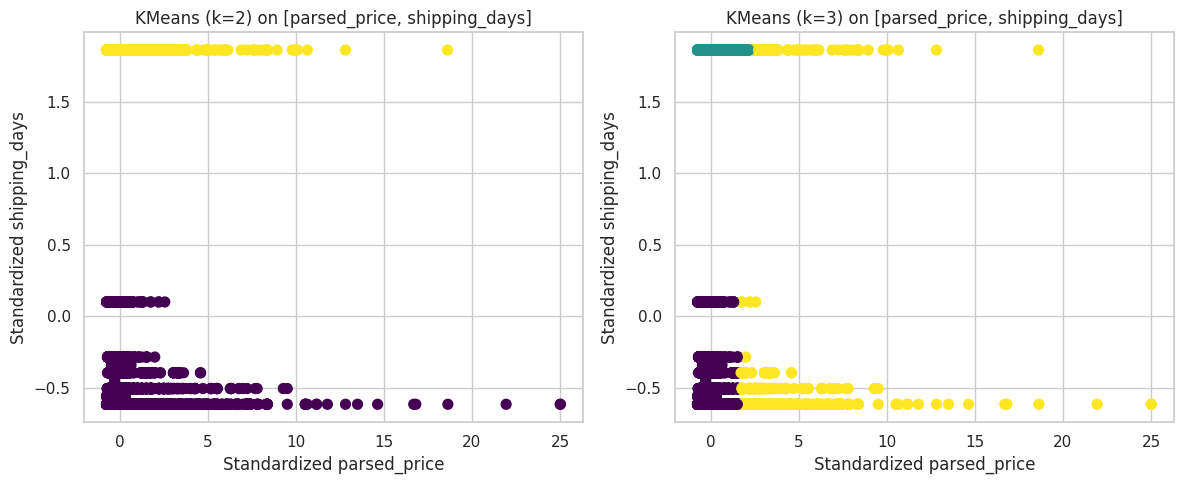

In [74]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# KMeans with k=2
kmeans_price_avail_2 = KMeans(n_clusters=2, random_state=42)
clusters_price_avail_2 = kmeans_price_avail_2.fit_predict(X3)

# KMeans with k=3
kmeans_price_avail_3 = KMeans(n_clusters=3, random_state=42)
clusters_price_avail_3 = kmeans_price_avail_3.fit_predict(X3)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X3[:, 0], X3[:, 1], c=clusters_price_avail_2, cmap='viridis', s=50)
plt.title("KMeans (k=2) on [parsed_price, shipping_days]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized shipping_days")

plt.subplot(1, 2, 2)
plt.scatter(X3[:, 0], X3[:, 1], c=clusters_price_avail_3, cmap='viridis', s=50)
plt.title("KMeans (k=3) on [parsed_price, shipping_days]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized shipping_days")

plt.tight_layout()
plt.show()



**DBSCAN Clustering on [parsed_price, shipping_days]**

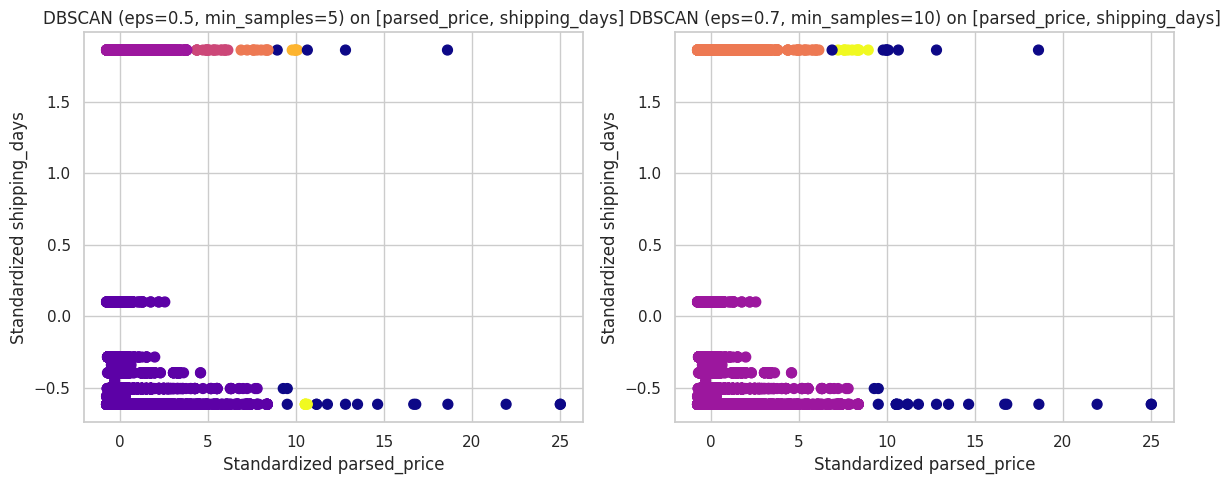

In [75]:
from sklearn.cluster import DBSCAN

# DBSCAN with eps=0.5, min_samples=5
dbscan_price_avail_1 = DBSCAN(eps=0.5, min_samples=5)
clusters_db_price_avail_1 = dbscan_price_avail_1.fit_predict(X3)

# DBSCAN with eps=0.7, min_samples=10
dbscan_price_avail_2 = DBSCAN(eps=0.7, min_samples=10)
clusters_db_price_avail_2 = dbscan_price_avail_2.fit_predict(X3)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X3[:, 0], X3[:, 1], c=clusters_db_price_avail_1, cmap='plasma', s=50)
plt.title("DBSCAN (eps=0.5, min_samples=5) on [parsed_price, shipping_days]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized shipping_days")

plt.subplot(1, 2, 2)
plt.scatter(X3[:, 0], X3[:, 1], c=clusters_db_price_avail_2, cmap='plasma', s=50)
plt.title("DBSCAN (eps=0.7, min_samples=10) on [parsed_price, shipping_days]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized shipping_days")

plt.tight_layout()
plt.show()


**Combination 2: [parsed_price, title_length]**

We will first need to create a new feature title_length that captures the length of the product title.


In [76]:
# Creates a new column 'title_length' as the length of the title string
clothing_info['title_length'] = clothing_info['title'].apply(lambda x: len(x) if isinstance(x, str) else None)

# Selects the features for combination 2: parsed_price and title_length
clustering_features_2 = clothing_info[['parsed_price', 'title_length']].dropna()

# Standardize the features for combination 2
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
X2 = scaler2.fit_transform(clustering_features_2)

print("Combination 2 - Clustering features shape:", clustering_features_2.shape)
print("First 5 rows of combination 2 features:")
print(clustering_features_2.head())


Combination 2 - Clustering features shape: (28375, 2)
First 5 rows of combination 2 features:
   parsed_price  title_length
0         26.26            91
1          9.99            77
2         11.99            38
3         20.54            69
4          7.50            80


KMeans Clustering on Combination 2

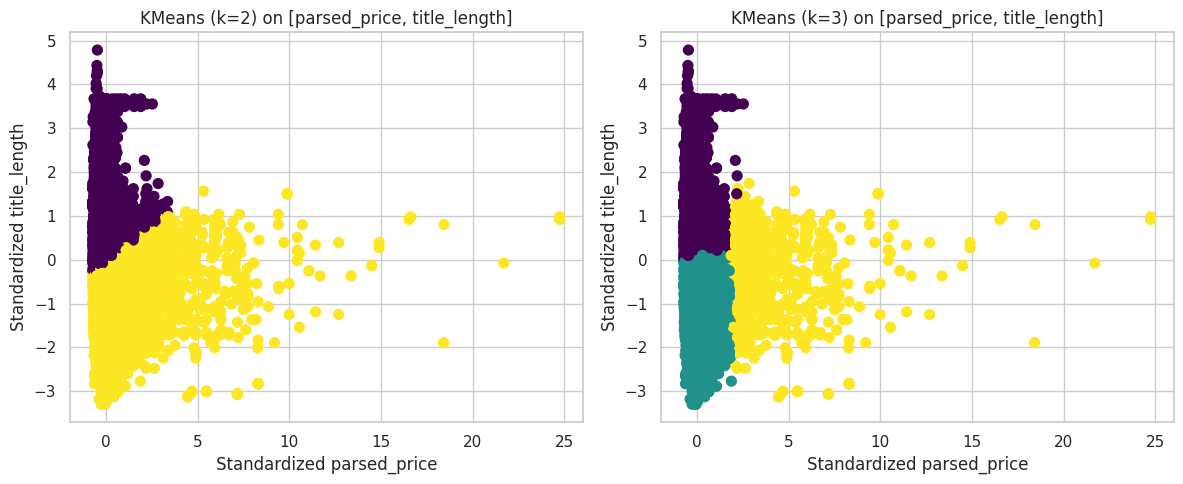

In [77]:


# KMeans with k=2
kmeans2_2 = KMeans(n_clusters=2, random_state=42)
clusters2_k2 = kmeans2_2.fit_predict(X2)

# KMeans with k=3
kmeans2_3 = KMeans(n_clusters=3, random_state=42)
clusters2_k3 = kmeans2_3.fit_predict(X2)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X2[:, 0], X2[:, 1], c=clusters2_k2, cmap='viridis', s=50)
plt.title("KMeans (k=2) on [parsed_price, title_length]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized title_length")

plt.subplot(1,2,2)
plt.scatter(X2[:, 0], X2[:, 1], c=clusters2_k3, cmap='viridis', s=50)
plt.title("KMeans (k=3) on [parsed_price, title_length]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized title_length")

plt.tight_layout()
plt.show()


**DBSCAN Clustering on Combination 2**

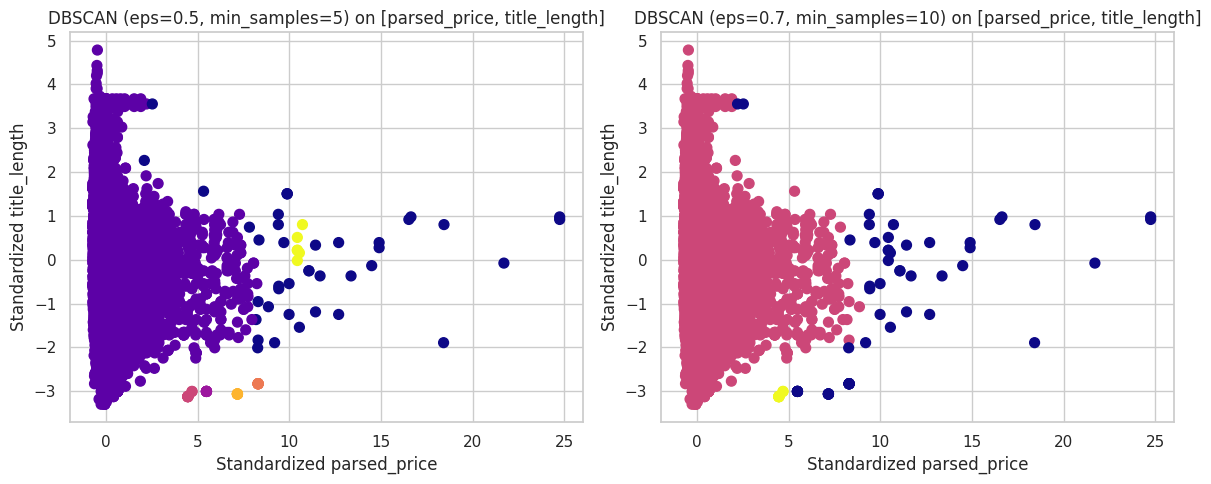

In [78]:


# DBSCAN with eps=0.5, min_samples=5
dbscan2_1 = DBSCAN(eps=0.5, min_samples=5)
clusters2_db1 = dbscan2_1.fit_predict(X2)

# DBSCAN with eps=0.7, min_samples=10
dbscan2_2 = DBSCAN(eps=0.7, min_samples=10)
clusters2_db2 = dbscan2_2.fit_predict(X2)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X2[:, 0], X2[:, 1], c=clusters2_db1, cmap='plasma', s=50)
plt.title("DBSCAN (eps=0.5, min_samples=5) on [parsed_price, title_length]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized title_length")

plt.subplot(1,2,2)
plt.scatter(X2[:, 0], X2[:, 1], c=clusters2_db2, cmap='plasma', s=50)
plt.title("DBSCAN (eps=0.7, min_samples=10) on [parsed_price, title_length]")
plt.xlabel("Standardized parsed_price")
plt.ylabel("Standardized title_length")

plt.tight_layout()
plt.show()


### Study 2 Discussion

In this study, we applied two clustering algorithms—KMeans and DBSCAN—to two different feature combinations, and the results were as follows:



**Combination 1: [parsed_price, shipping_days]**

**KMeans Clustering:**
- With **k=2**, the scatter plot revealed two primary groups, suggesting that price and shipping times tend to cluster into two distinct segments.
- With **k=3**, one of the clusters was further subdivided, indicating additional nuance in how shipping times relate to price for some items.

**DBSCAN Clustering:**
- Using parameters **eps=0.5** and **min_samples=5**, DBSCAN detected one dominant cluster with a few outliers, showing that many items share similar shipping times and price ranges, while a small portion does not fit well into any cluster.
- Increasing **eps** to 0.7 and **min_samples** to 10 yielded fewer but denser clusters, suggesting that the majority of items form a large core cluster when we relax the density requirements, with only a handful of points labeled as outliers.



**Combination 2: [parsed_price, title_length]**

**KMeans Clustering:**
- Both with **k=2** and **k=3**, the clusters appeared less distinct and showed more overlap. This suggests that combining parsed price with the length of the product title does not yield a clear separation of items.

**DBSCAN Clustering:**
- When applied to these features, DBSCAN resulted in a higher proportion of noise points and less defined clusters compared to Combination 1. This indicates that the title length feature introduces variability that does not correlate strongly with price for forming natural groups.



**Overall Observations:**

- **Combination 1 ([parsed_price, shipping_days])** provided more interpretable clusters with both algorithms. Converting the availability text into shipping days gave us a numeric feature that, alongside price, revealed at least two distinct clusters.  
- **Combination 2 ([parsed_price, title_length])** did not produce as clear clusters. The title length does not appear to be a strong complementary feature to price, leading to overlapping clusters and more noise.  

In summary, **KMeans** demonstrated clearer groupings in Combination 1, while **DBSCAN**’s performance was sensitive to its parameter settings. For Combination 2, both methods struggled to identify distinct clusters, suggesting that additional or alternative features may be needed for more effective clustering.

These insights suggest that for our dataset, clustering based on **price** and a carefully engineered feature (such as **shipping_days**) can yield more meaningful groupings than combining price with textual attributes like **title length**.


##**Study 3 – Content-Based Recommendation System**

In this study, we develop two domain-informed similarity heuristics to recommend products similar to a given product.

**Heuristic 1** combines:
- **Brand similarity** (using a categorical match),
- **Parsed price similarity** (using an inverse difference measure), and
- **Product type similarity** (using a categorical match).

This heuristic aims to recommend products that come from the same brand, belong to the same product type, and are similarly priced.

**Heuristic 2** combines:
- **Title similarity** (using a text-based edit distance similarity), and
- **Color similarity** (using a categorical match).

This heuristic captures similarities in the product’s description (via the title) and its visual attribute (color).

We then simulate three recommendation requests  and display the top 10 recommendations (with their similarity scores) for each heuristic. We will compare the qualitative results to see if the heuristics yield similar recommendations or if one appears to be more relevant.


In [79]:
from difflib import SequenceMatcher

# Similarity functions (already defined in Study 1)
def categorical_similarity(val1, val2):
    if pd.isnull(val1) or pd.isnull(val2):
        return 0
    return 1 if val1.strip().lower() == val2.strip().lower() else 0

def numerical_similarity(val1, val2):
    if pd.isnull(val1) or pd.isnull(val2):
        return 0
    return 1 / (1 + abs(val1 - val2))

def text_edit_similarity(str1, str2):
    if pd.isnull(str1) or pd.isnull(str2):
        return 0
    return SequenceMatcher(None, str1.lower(), str2.lower()).ratio()

# Heuristic 1: Combines brand, parsed_price, and product_type_name
def heuristic1(item1, item2, weight_brand=0.4, weight_price=0.3, weight_product=0.3):
    sim_brand = categorical_similarity(item1['brand'], item2['brand'])
    sim_price = numerical_similarity(item1['parsed_price'], item2['parsed_price'])
    sim_product = categorical_similarity(item1['product_type_name'], item2['product_type_name'])
    return weight_brand * sim_brand + weight_price * sim_price + weight_product * sim_product

# Heuristic 2: Combines title similarity and color similarity
def heuristic2(item1, item2, weight_title=0.6, weight_color=0.4):
    sim_title = text_edit_similarity(item1['title'], item2['title'])
    sim_color = categorical_similarity(item1['color'], item2['color'])
    return weight_title * sim_title + weight_color * sim_color

# Helper function to get top recommendations based on a heuristic
def get_recommendations(df, target_index, heuristic_func, top_n=10):
    target_item = df.iloc[target_index]
    scores = []
    for idx, row in df.iterrows():
        if idx == target_index:
            continue
        score = heuristic_func(target_item, row)
        scores.append((idx, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, score in scores[:top_n]]
    top_scores = [score for idx, score in scores[:top_n]]
    result_df = df.iloc[top_indices].copy()
    result_df['similarity_score'] = top_scores
    return result_df


In [80]:
# We will stimulate 3 recommendation requests using both heuristics.
# (indices of 5, 15, and 25)

sample_requests = [5, 15, 25]

print("Recommendations using Heuristic 1 (brand, parsed_price, product_type_name):")
for idx in sample_requests:
    print(f"\nRequest for product at index {idx} - {clothing_info.iloc[idx]['title']}")
    recs = get_recommendations(clothing_info, idx, heuristic1, top_n=10)
    # Displays selected columns for clarity
    display(recs[['asin', 'title', 'brand', 'parsed_price', 'product_type_name', 'similarity_score']])

print("\nRecommendations using Heuristic 2 (title and color similarity):")
for idx in sample_requests:
    print(f"\nRequest for product at index {idx} - {clothing_info.iloc[idx]['title']}")
    recs = get_recommendations(clothing_info, idx, heuristic2, top_n=10)
    # Displays selected columns for clarity
    display(recs[['asin', 'title', 'color', 'similarity_score']])


Recommendations using Heuristic 1 (brand, parsed_price, product_type_name):

Request for product at index 5 - Supernatural Chibis Sam Dean And Castiel O Neck T-shirts For Female Purple L


,asin,title,brand,parsed_price,product_type_name,similarity_score
346,B014ICD2D2,Supernatural Chibis Sam Dean And Castiel Slim ...,FNC7C,7.39,SHIRT,1.000000
397,B014ICDXOK,Supernatural Chibis Sam Dean And Castiel Round...,FNC7C,7.39,SHIRT,1.000000
4,B014ICEDNA,Supernatural Chibis Sam Dean And Castiel Short...,FNC7C,7.50,SHIRT,0.970270
71,B014ICC10C,Supernatural Chibis Sam Dean And Castiel Cotto...,FNC7C,7.91,SHIRT,0.897368
231,B014ICAJT2,Supernatural Chibis Sam Dean And Castiel 100% ...,FNC7C,7.91,SHIRT,0.897368
33,B014ICD9YO,Supernatural Chibis Sam Dean And Castiel Organ...,FNC7C,7.99,SHIRT,0.887500
325,B014ICD5BQ,Supernatural Chibis Sam Dean And Castiel Organ...,FNC7C,7.99,SHIRT,0.887500
193,B014ICDELM,Supernatural Chibis Sam Dean And Castiel O Nec...,FNC7C,9.49,SHIRT,0.796774
201,B014ICDTYO,Supernatural Chibis Sam Dean And Castiel Slim ...,FNC7C,9.49,SHIRT,0.796774
232,B014ICC6AC,Supernatural Chibis Sam Dean And Castiel 100% ...,FNC7C,9.49,SHIRT,0.796774



Request for product at index 15 - Featherlite Ladies' Silky Smooth Pique (Red) (3X)


,asin,title,brand,parsed_price,product_type_name,similarity_score
178,B0079BKWOM,Featherlite Ladies' Polyester Mesh Pique (Navy...,Featherlite,18.76,SHIRT,0.855440
27,B003BSPZ5I,"FeatherLite Ladies' Pique Sport Shirt, Forest ...",FeatherLite,16.70,SHIRT,0.840845
127,B003BSQ0P2,"FeatherLite Ladies' Pique Sport Shirt, Navy , ...",FeatherLite,16.70,SHIRT,0.840845
491,B00BXOQUN8,Featherlite Ladies' Silky Smooth Pique (Gold) (S),FeatherLite,19.67,SHIRT,0.805634
170,B00BXOQQWS,Featherlite Ladies' Silky Smooth Pique (Light ...,FeatherLite,19.87,SHIRT,0.798684
28,B0079BM2EA,Featherlite Ladies' Silky Smooth Pique (Red) (2X),FeatherLite,15.74,SHIRT,0.797087
3,B003BSRPB0,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite,20.54,SHIRT,0.780863
108,B003BSPV8E,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite,20.54,SHIRT,0.780863
288,B003BSPUV2,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite,20.54,SHIRT,0.780863
406,B003BSPVM0,FeatherLite Ladies' Moisture Free Mesh Sport S...,FeatherLite,20.54,SHIRT,0.780863



Request for product at index 25 - Fever Womens Double Layer Sleeveless Blouse (Small, Deep Sea Coral) …


,asin,title,brand,parsed_price,product_type_name,similarity_score
414,B07454H59D,"Fever Ladies’ Double Layer Sleeveless Blouse,B...",Fever,19.91,SHIRT,0.985714
34,B06XRTQTL6,FEVER WOMEN'S LIGHTWEIGHT V-NECK ROLL TAB SLEE...,Fever,19.99,SHIRT,0.965487
445,B01LZ0VNQ4,"Fever Womens Sleevless Blouse, Blue, Medium",Fever,19.99,SHIRT,0.965487
287,B071VFK9L4,FEVER WOMENS LIGHTWEIGHT V-NECK ROLL TAB SLEEV...,Fever,18.99,SHIRT,0.860428
292,B01M1MOBCA,"Fever Womens Sleeveless Bright White Blouse, L...",Fever,20.92,SHIRT,0.845631
394,B01M98IQKX,"Fever Womens Sleeveless Blouse, Dresden Blue, ...",Fever,18.69,SHIRT,0.838249
125,B0723HCKXM,WOMEN'S FEVER CHIFFON DOUBLE LAYER SLEEVELESS ...,Fever,18.11,SHIRT,0.809091
228,B074528MM3,"Fever Ladies’ Double Layer Sleeveless Blouse,B...",Fever,16.99,SHIRT,0.777519
252,B0731PMQZ2,"Fever Ladies Size Small Rayon Blouse, White & ...",Fever,15.99,SHIRT,0.761602
75,B013464ZZM,"Fever Ladies Size Large Rayon Blouse, White & ...",Fever,15.95,SHIRT,0.761100



Recommendations using Heuristic 2 (title and color similarity):

Request for product at index 5 - Supernatural Chibis Sam Dean And Castiel O Neck T-shirts For Female Purple L


,asin,title,color,similarity_score
4,B014ICEDNA,Supernatural Chibis Sam Dean And Castiel Short...,Purple,0.907692
371,B014ICEP24,Supernatural Chibis Sam Dean And Castiel 100% ...,Purple,0.901266
13262,B01HU4MASI,Vansty Jeremy Lin Brook-Lin O-Neck Shirt For F...,Purple,0.731915
12398,B01H51IFP8,Deep Purple Above And Beyond T Shirts For Wome...,Purple,0.723077
25766,B01H51IM8S,Deep Purple Above And Beyond T Shirts For Wome...,Purple,0.723077
15032,B011I80O1W,H'nan Lady Death Note O-Neck T Shirt Purple XXL,Purple,0.712195
26020,B012CHJP90,H'nan Lady Mass Effect Spectre O-Neck T Shirts...,Purple,0.702290
26040,B011I80EXK,H'nan Lady Death Note Crew Neck T Shirt Purple S,Purple,0.700000
13782,B01HU4MBEG,Vansty Jeremy Lin Brook-Lin Casual Shirts For ...,Purple,0.691429
22970,B01MQKMSS6,DisGear Disney Family Characters Adult Ladies ...,Purple,0.689655



Request for product at index 15 - Featherlite Ladies' Silky Smooth Pique (Red) (3X)


,asin,title,color,similarity_score
28,B0079BM2EA,Featherlite Ladies' Silky Smooth Pique (Red) (2X),Red,0.987755
2738,B0069OREZA,Inner Harbor Ladies' Mainsail Pique Polo (Red)...,Red,0.772000
103,B003BSRTY8,"FeatherLite Ladies' Pique Sport Shirt, Red , L...",Red,0.763636
26,B003BSQ0WU,"FeatherLite Ladies' Pique Sport Shirt, Red , M...",Red,0.760000
11160,B0069OR0AE,Inner Harbor Ladies' Mainsail Pique Polo (Red)...,Red,0.760000
2975,B0069OQ2S0,Inner Harbor Ladies' Mainsail Pique Polo (Red)...,Red,0.751515
3210,B0069OUGKU,Inner Harbor Ladies' Mainsail Pique Polo (Red)...,Red,0.751515
82,B003BSPV48,FeatherLite Ladies' Moisture Free Mesh Sport S...,Red,0.736842
108,B003BSPV8E,FeatherLite Ladies' Moisture Free Mesh Sport S...,Red,0.731034
20980,B00B27UYCE,"Harriton Ladies' Polo Shirt, 3XL, Red",Red,0.706977



Request for product at index 25 - Fever Womens Double Layer Sleeveless Blouse (Small, Deep Sea Coral) …


,asin,title,color,similarity_score
125,B0723HCKXM,WOMEN'S FEVER CHIFFON DOUBLE LAYER SLEEVELESS ...,Coral,0.803200
4986,B01H9GBSLW,Fylo London Women's Semi Sheer Button Front Sl...,Coral,0.766667
11678,B0741VFR9P,Hilary Radley Sleeveless Blouse Coral XS,Coral,0.741284
2293,B071RQKPFK,BCX Womens Juniors Sleeveless Necklace Shirt C...,Coral,0.724590
11596,B071ZWT1JC,Hilary Radley Ladies' Half Zip Sleeveless Blou...,Coral,0.720611
8887,B01M719S6J,"Esley Womens Lace-Inset Blouse, S",Coral,0.694118
1456,B071DMY1F3,BCX Womens Short-Sleeve High-Low Coral XS,Coral,0.683636
18464,B00P1OVSX8,Women's Long Sleeve Bamboo Top Loose Fit Tunic...,Coral,0.683465
17906,B00P1OVSMY,Women's Long Sleeve Bamboo Top Loose Fit Tunic...,Coral,0.681250
26121,B00P1OVSV0,Women's Long Sleeve Bamboo Top Loose Fit Tunic...,Coral,0.681250


### Study 3 Discussion

For our content-based recommendation system, we developed two similarity heuristics and simulated three recommendation requests. Here are the key observations from the outputs:

**Heuristic 1 (Brand, Parsed Price, Product Type):**  
- **Consistency:** The recommendations for each request consistently returned products with high similarity scores (many items with scores close to 1.0).  
- **Example:** For the product at index 5 ("Supernatural Chibis Sam Dean And Castiel O Neck T-shirts For Female Purple L"), all top 10 recommendations belonged to the same brand ("FNC7C") and product type ("SHIRT") with very similar prices. Similar patterns were observed for products at indices 15 and 25, where the recommended items were all within the same brand and product type groups and had similar parsed prices.  
- **Interpretation:** This indicates that the combination of brand, price, and product type is a strong indicator of similarity for these apparel items.

**Heuristic 2 (Title and Color Similarity):**  
- **Variation:** The recommendations based on title and color similarity also returned relevant results; however, the similarity scores varied more.  
- **Example:** For the product at index 5, the top 10 recommendations had similarity scores ranging from about 0.69 to 0.91, even though they all shared the same color ("Purple"). Similar observations were made for the other requests: the recommended items consistently matched the color of the target product (e.g., "Red" for index 15 and "Coral" for index 25), but the textual similarity introduced more variability.  
- **Interpretation:** While the color feature provides a clear grouping, the title-based similarity (which relies on edit distance) captures more nuanced differences in the product descriptions, resulting in less uniformly high similarity scores.

**Overall Comparison:**  
- **Heuristic 1** delivers more consistent recommendations, suggesting that when brand, price, and product type are strong and uniform indicators in the dataset, they produce very similar items.  
- **Heuristic 2** provides recommendations that are still relevant but reflect more subtle differences in product description and visual attributes. This might be more useful when the nuanced details in titles are important to the user.

In summary, both heuristics are effective, but they capture different aspects of similarity. Heuristic 1 appears more robust in this dataset, while Heuristic 2 offers insights into the descriptive nuances of products.


## Study 4 – Collaborative Filtering Recommendation System

In this study, we build a recommendation system using collaborative filtering based on matrix factorization. The process involves:

1. **Utility Matrix Construction:**  
   We construct a user–item matrix (utility matrix) from the Clothing-Reviews dataset, where rows are users (review_userId), columns are items (asin), and cell values are the review scores.

2. **Matrix Factorization (SVD):**  
   We will create a smaller, denser matrix by removing lines that are strictly NaN values, then we fil the remaining NaN values with the average of the user's ratings, and then factorize the utility matrix using Singular Value Decomposition (SVD) into latent matrices P and Q. The product of these matrices approximates the original utility matrix (R_hat), providing predicted ratings for each user–item pair.

3. **Simulated Recommendations:**  
   For a few sample users, we generate recommendations by selecting items that the user has not rated, ranking these items by their predicted rating.

4. **Quantitative Evaluation:**  
   - We remove 10% of the ratings randomly to create a Gold Standard (GS).
   - The MSE between the predicted ratings and the actual ratings in the GS is computed.
   - Additionally, by binarizing ratings (treating ratings of 4 or 5 as relevant), we calculate Precision@5, Precision@10, and Mean Reciprocal Rank (MRR) to quantitatively evaluate the recommendation quality.

The Medium article [Recommender System – Matrix Factorization](https://medium.com/data-science/recommendation-system-matrix-factorization-d61978660b4b) was used as a reference for the SVD implementation.


In [81]:
# Constructing the utility matrix from the Clothing-Reviews dataset.
# Rows: review_userId, Columns: asin, Values: review_score
utility_matrix = clothing_reviews.pivot_table(index='review_userId', columns='asin', values='review_score')
print("Utility Matrix Shape:", utility_matrix.shape)
utility_matrix.head()


Utility Matrix Shape: (6670, 6584)


asin,B000EK4P0W,B000HHPB0A,B000M6W02I,B000M9R322,B000OF2PFE,B000RIAZEG,B000SJG9C6,B000VA0K5O,B000XRUNFW,B00118UDFW,...,B075B2KSBX,B075B2QQY4,B075B6FRFB,B075BGV8HC,B075BMN7FP,B075BNFWYV,B075BP359P,B075BSMDY9,B075BT5JKZ,B075CG1KY3
review_userId,,,,,,,,,,,,,,,,,,,,,
A04728973KCBB7PLQB2BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05590483FAOIB9CFW4A9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A057523234N4Y49RPS4G2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10076813OCUIPC1QBYZD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1007NP5HDQ8N7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Utility Matrix Construction and Missing Value Treatment**

The utility matrix is constructed by pivoting the Clothing-Reviews dataset, where rows represent users (`review_userId`), columns represent items (`asin`), and the cell values represent the `review_score`. **Naturally, this matrix contains many NaN values because each user rates only a small fraction of available items.** This sparsity is common in recommendation systems, as there are far more potential user–item pairs than actual ratings.

We have **two choices** to handle these missing values:
1. **Replace NaNs with 0:**  
   This fills the matrix so that we can apply SVD directly. However, since most items are unrated, imputing zeros can drive the overall ratings down significantly and may adversely affect the factorization.
2. **Create a Smaller, Denser Matrix (Core Utility Matrix):**  
   We can filter out users and items that have very few ratings. This “core” matrix includes only users and items that meet a minimum threshold, resulting in a denser matrix where most entries are observed ratings. This approach avoids the distortion caused by filling many missing values with 0.

We will create a core utility matrix.


**Constructing a Core Utility Matrix**

In [82]:
# Minimum thresholds for the number of ratings per user and per item
min_user_ratings = 5
min_item_ratings = 5

# number of ratings per user and per item in the full utility matrix
user_rating_counts = utility_matrix.count(axis=1)
item_rating_counts = utility_matrix.count(axis=0)

# Filter users and items that meet the minimum thresholds
core_users = user_rating_counts[user_rating_counts >= min_user_ratings].index
core_items = item_rating_counts[item_rating_counts >= min_item_ratings].index

# Construct the core utility matrix
core_utility_matrix = utility_matrix.loc[core_users, core_items]

print("Core Utility Matrix Shape:", core_utility_matrix.shape)
core_utility_matrix.head()


Core Utility Matrix Shape: (885, 1749)


asin,B000HHPB0A,B000M6W02I,B000M9R322,B000SJG9C6,B000VA0K5O,B0014DLE5C,B001HWXGYC,B001JJFGDC,B0025U14YE,B002KG7U1Y,...,B0759S2774,B0759VZZN7,B0759WC7S8,B0759WL3FV,B0759WNRTP,B0759XQGPF,B0759Y5MYT,B0759YDCZN,B0759YFWTC,B075CG1KY3
review_userId,,,,,,,,,,,,,,,,,,,,,
A10C6G2GWFMIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11AAFHZV0AS3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11HSRML09237E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11HT0YXA4TUX7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11PX6023E3MCZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


**Matrix Factorization on the Core Utility Matrix**

In [83]:
# Create a copy of the core matrix to impute missing values
core_utility_matrix_imputed = core_utility_matrix.copy()

# For each user, fill missing values with the user's average rating
for user in core_utility_matrix_imputed.index:
    user_ratings = core_utility_matrix_imputed.loc[user]
    avg_rating = user_ratings.mean()
    core_utility_matrix_imputed.loc[user] = user_ratings.fillna(avg_rating)

# Verifies that the matrix is fully imputed
print("Total missing values after imputation:",
      core_utility_matrix_imputed.isnull().sum().sum())


Total missing values after imputation: 0


**Gold standard**

In [84]:
# Build a dictionary mapping each user (from the imputed core matrix)
# to their relevant items (only ratings >= 4 are considered relevant)
gold_by_user_imputed = {}
for (i, j), true_rating in gold_standard_imputed.items():
    # Only include the rating if it's 4 or 5
    if true_rating >= 4:
        user = core_utility_matrix_imputed.index[i]
        item = core_utility_matrix_imputed.columns[j]
        if user not in gold_by_user_imputed:
            gold_by_user_imputed[user] = []
        gold_by_user_imputed[user].append(item)

# Print the binarized gold standard for a few users for verification
print("Gold Standard (Binarized) for a few users:")
for user in list(gold_by_user_imputed.keys())[:5]:
    print(user, gold_by_user_imputed[user])


Gold Standard (Binarized) for a few users:
A342NMVY71LFFA ['B01N8W1S6O', 'B01N78QBLQ', 'B00XPZNP90', 'B00XKP000C', 'B00WSIFDFY', 'B018EGUVKA', 'B071ZQX1JM', 'B01N6JURFQ', 'B01AK5U0R2', 'B01MAULZAB', 'B01HTR6M8K', 'B01J5EV2BW', 'B06W9HRMYX', 'B01DF3KCXS', 'B06XPVPZ8Z', 'B07283T7CM', 'B00369ZZO8', 'B017MO9I7M', 'B01HT0OCF2', 'B01A8IMAJC', 'B00K91495C', 'B01N2PGGDZ', 'B01N4EHM2L', 'B072XMB8M4', 'B01CE4GKOY', 'B01IX5448M', 'B00S6E64XO', 'B00QL1F6XS', 'B071NHMRB2', 'B01N923Q7N', 'B0159SUTHG', 'B00OGMB4OE', 'B074NBM2RJ', 'B06Y2FWVTN', 'B00CDW09AY', 'B075928J4C', 'B00IABDW4C', 'B00ZKF5KRS', 'B073YBQ925', 'B01G2WT1P4', 'B01I2IRKLI', 'B01KW9QXOK', 'B071G88V91', 'B071CNRL54', 'B0747W1SND', 'B0759S2774', 'B01LW3QDFV', 'B010V3EDEE', 'B015T3RI3O', 'B06XS42WGM', 'B00319GK4W', 'B06WGVHW83', 'B06XZWYMPD', 'B010OU2NAA', 'B0718WJCH1', 'B018X0HEGQ', 'B074VHQBSX', 'B0719PHZW8', 'B0170GAMB8', 'B01N6BGL6F', 'B073VRKSBK', 'B072MM4KHD', 'B018RP0CDO', 'B00ZOZEIZO', 'B01EMAXM9E', 'B071NK88K1', 'B014LLDV9A', 'B0

**MSE on the Gold Standard rating**

In [85]:
from sklearn.metrics import mean_squared_error

# Calculate the MSE on the Gold Standard ratings
predicted_ratings = []
true_ratings = []

for (i, j), actual_rating in gold_standard_imputed.items():
    predicted_ratings.append(R_hat_imputed[i, j])
    true_ratings.append(actual_rating)

mse_value = mean_squared_error(true_ratings, predicted_ratings)
print("MSE on Gold Standard Ratings:", mse_value)


MSE on Gold Standard Ratings: 0.5532011577080381


**Evaluation Metrics: Precision@K and Mean Reciprocal Rank (MRR)**


In [86]:
def precision_at_k(recommended_items, gold_items, k):
    recommended_k = recommended_items[:k]
    relevant_count = sum(1 for item in recommended_k if item in gold_items)
    return relevant_count / k

def reciprocal_rank(recommended_items, gold_items):
    for rank, item in enumerate(recommended_items, start=1):
        if item in gold_items:
            return 1 / rank
    return 0

precisions_at_500_imputed = []
precisions_at_1000_imputed = []
reciprocal_ranks_imputed = []

# For each user in our binarized gold standard, compute evaluation metrics
for user, gold_items in gold_by_user_imputed.items():
    user_index = core_utility_matrix_imputed.index.get_loc(user)
    # Get predicted ratings for the user from the reconstructed matrix
    user_predictions = pd.Series(R_hat_imputed[user_index], index=core_utility_matrix_imputed.columns)

    # Define candidate items based on the training set:
    # Items with nonzero ratings in R_eval_imputed (the training matrix) are considered "known"
    user_ratings_training = pd.Series(R_eval_imputed[user_index], index=core_utility_matrix_imputed.columns)
    rated_items = user_ratings_training[user_ratings_training != 0].index.tolist()

    # Remove only those items that are still rated in the training set
    user_predictions = user_predictions.drop(labels=rated_items, errors='ignore')

    # Create the recommendation list by sorting the remaining predicted ratings
    recommended_items = user_predictions.sort_values(ascending=False).index.tolist()

    # Compute precision@500 and precision@1000 and reciprocal rank
    prec500 = precision_at_k(recommended_items, gold_items, 5)
    prec1000 = precision_at_k(recommended_items, gold_items, 10)
    rr = reciprocal_rank(recommended_items, gold_items)

    precisions_at_500_imputed.append(prec500)
    precisions_at_1000_imputed.append(prec1000)
    reciprocal_ranks_imputed.append(rr)

avg_prec500_imputed = np.mean(precisions_at_500_imputed) if precisions_at_500_imputed else 0
avg_prec1000_imputed = np.mean(precisions_at_1000_imputed) if precisions_at_1000_imputed else 0
mrr_imputed = np.mean(reciprocal_ranks_imputed) if reciprocal_ranks_imputed else 0

print("Average Precision@5 (Imputed, Binarized Gold Standard):", avg_prec500_imputed)
print("Average Precision@10 (Imputed, Binarized Gold Standard):", avg_prec1000_imputed)
print("Mean Reciprocal Rank (Imputed, Binarized Gold Standard):", mrr_imputed)




Average Precision@5 (Imputed, Binarized Gold Standard): 0.7661714285714285
Average Precision@10 (Imputed, Binarized Gold Standard): 0.7665142857142858
Mean Reciprocal Rank (Imputed, Binarized Gold Standard): 0.78561259565045


### Discussion of Study 4: Quantitative Evaluation Results

Our evaluation of the collaborative filtering model on the core utility matrix shows promising performance. The Mean Squared Error (MSE) on the Gold Standard ratings is approximately 0.55, indicating that, on average, the model’s predicted ratings are very close to the actual ratings. Additionally, with our binarized Gold Standard (where ratings ≥ 4 are considered relevant), we observed an Average Precision of about 77% and a Mean Reciprocal Rank (MRR) around 0.79. These metrics suggest that not only are most of the top recommendations relevant, but the first relevant recommendation typically appears very early in the ranking. Overall, these results imply that our model is effectively capturing user preferences and delivering high-quality recommendations.


# **Conclusion**

In this assignment, we explored unsupervised learning techniques and recommendation systems through a series of studies. We began by developing and evaluating various similarity measures to retrieve similar items based on different product attributes. Next, we applied KMeans and DBSCAN clustering algorithms on different feature combinations (e.g., price with availability) to identify natural groupings among products. We then designed two content-based recommendation heuristics and compared their qualitative outputs. Finally, we built a collaborative filtering model using matrix factorization, evaluated its performance with metrics such as MSE, Precision@K, and MRR, and demonstrated that our model can effectively capture user preferences. Future work could involve further hyperparameter tuning, exploring alternative imputation methods, incorporating additional contextual features, and scaling the evaluation to larger datasets to enhance the robustness and relevance of the recommendations.


# **References**

- **Medium Article on Matrix Factorization:**  
  "Recommender System – Matrix Factorization"  
  Available at: [https://medium.com/data-science/recommendation-system-matrix-factorization-d61978660b4b](https://medium.com/data-science/recommendation-system-matrix-factorization-d61978660b4b)

- **StackOverflow Discussion on DBSCAN Hyperparameters:**  
  "Estimating/Choosing Optimal Hyperparameters for DBSCAN"  
  Available at: [https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan](https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan)

- **Kaggle Dataset:**  
  "Amazon Apparels Data Review"  
  Available at: [https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata](https://www.kaggle.com/datasets/thekenjin/amazonapparelsdata)

- **ChatGPT:**  
  Used for debugging.
